In [56]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile


fs, modulator = wavfile.read('modulator.wav')
fs1, carrier = wavfile.read('organ_carrier.wav')
print(modulator.shape, carrier.shape)
print(f"fs: {fs}, fs1: {fs1}")


carrier = carrier[:min(len(modulator), len(carrier))]
modulator = modulator[:min(len(modulator), len(carrier))]

print(len(carrier))
print(len(modulator))

Audio(modulator, rate=fs)

(49134,) (70562,)
fs: 22050, fs1: 22050
49134
49134


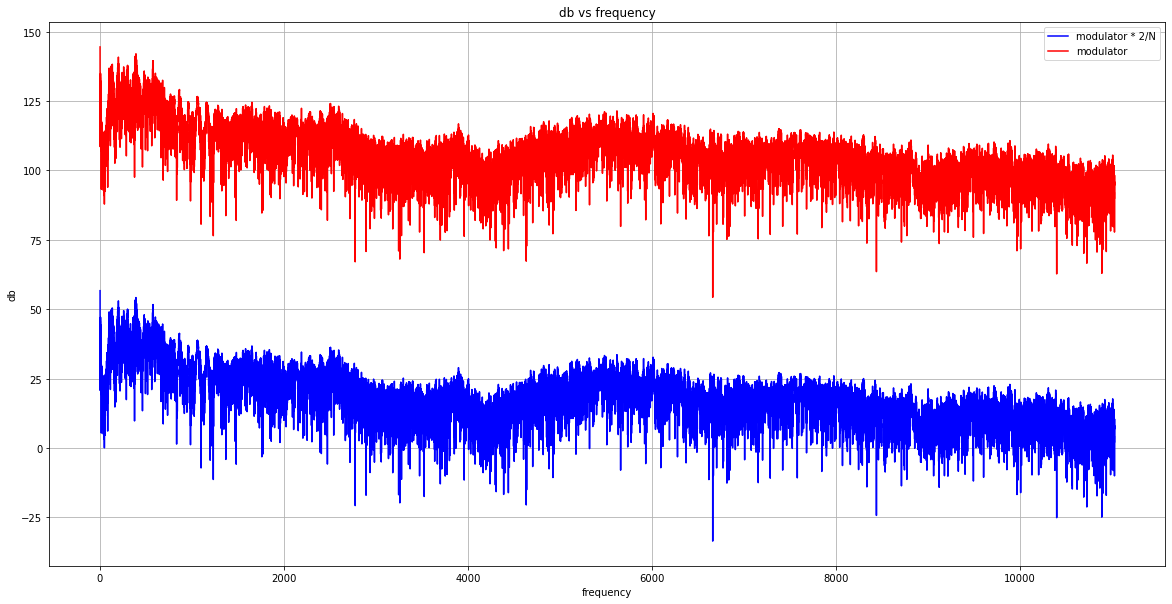

In [28]:
modulator_fft = np.fft.fft(modulator)

N = len(modulator)
freq_spec = np.arange(N/2)*fs/(N)
# my_dft = 2/N * np.abs(dft(test_signal[:N]))
# my_dft = 20. * np.where(my_dft>0., np.log10(my_dft), 0)

# my_dft = 20. * np.log10(2/N * np.abs( dft(tmp[:N]) ) )
modulator_fft_divN = 20. * np.log10(2/N * np.abs( modulator_fft ) )
modulator_fft = 20. * np.log10( np.abs( modulator_fft ) )

plt.figure(figsize=(20,10))
plt.plot(freq_spec, modulator_fft_divN[:N//2], color = "blue", label = "modulator * 2/N")
plt.plot(freq_spec, modulator_fft[:N//2], color = "red", label = "modulator")
plt.grid()
plt.legend(loc = 'upper right')
plt.title("db vs frequency")
plt.xlabel("frequency")
plt.ylabel("db")
plt.show()


In [78]:
def get_stft(signal, L, delta_m, window_fn=None):
    """
    :param signal: time-sampled signal
    :param L: window size per DFT in samples
    :param delta_m: how many samples the window is moved 
    :param conv: convolution function for signal
    
    :return L x ms matrix where each column is a single dft frame 
    """
    N = len(signal)
    ms = np.arange(0, N-L, delta_m)
    dfts = None
    for m in ms:
        window = signal[m:m+L]
        if window_fn:
            window = window * window_fn
        freq_window = np.array([np.fft.fft(window)]).T
        dfts = freq_window if dfts is None else np.hstack([
            dfts, 
            freq_window
        ])
    return ms, dfts

def get_istft(stft, delta_m, window_fn=None):
    L = stft.shape[0]
    signal = np.array([])
    m = delta_m
    for col in range(stft.shape[1]):
        signal_window = np.fft.ifft(stft[:, col])
        if col % 100 == 0:
            print(m)
            print(signal_window.shape)
        if window_fn:
            signal_window = signal_window / window_fn
        signal = np.concatenate([
            signal[:m],
            signal_window
        ])
        m += delta_m
    return signal * (1/L)

def plot_spectrogram(ms, stft, fs, hop, colorbar=False):    
    plt.figure(figsize=[20,20])
    L = stft.shape[0]
    # we only look at DFT freq up to nyquist limit fs/2, and normalize out imag components
    stft_db = 20*np.log10(np.abs(stft[:L//2, :])*2)
    plt_spec = plt.imshow(
        stft_db,
        origin='lower'
    )
    
    ## create ylim
    num_yticks = 10
    ks = np.linspace(0, L/2, num_yticks)
    ks_hz = ks * fs // (L)
    plt.yticks(ks,ks_hz)
    plt.ylabel("Frequency (Hz)")

    ## create xlim
    num_xticks = 10
    ts_spec = np.linspace(0, len(ms), num_xticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0, ms[-1]/fs, num_xticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title(f"Spectrogram L={L} hopsize={hop}, fs={fs} Spectrogram.shape={stft.shape}")
    if colorbar:
        plt.colorbar(None, use_gridspec=True)
    plt.show()
    return(plt_spec)


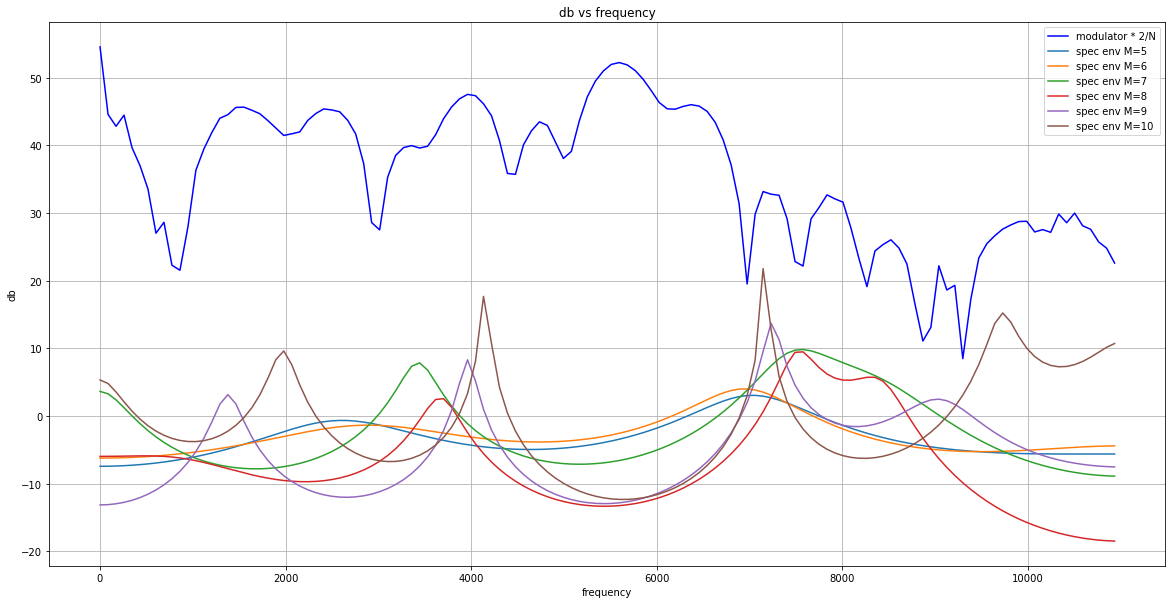

In [89]:

def gen_autocorrelates(x, M):
    """
    returns [r_0, r_1, ..., r_M]
    """
    rx = np.correlate(x, x, "full")
    start = len(rx)//2
    return rx[start:start+M+1]

def gen_toeplitz(rx, M):
    covmatrix = np.zeros((M,M))
    for i in range(0,M):
        for j in range(0,M):
            covmatrix[i, j] = rx[np.abs(i-j)]
    return covmatrix

def gen_lp_coeffs(x, M):
    rx = gen_autocorrelates(x, M)
    toeplitz = gen_toeplitz(rx, M)
#     print(f"rx shape:{rx[1:].shape}, toe shape: {toeplitz.shape}")
          
    coeffs, _, _, _ = np.linalg.lstsq(
        toeplitz,
        -1*rx[1:], 
        rcond=None
    )
    # np.linalg.solve((covmatrix),-1*np.array(r_p), rcond=None)
#     print(np.dot(toeplitz, coeffs) + rx[1:])
    return np.concatenate(([1], coeffs))


def gen_lpc_spec_envs(modulator, L, hop, M, nfft=None):
    """
    It receives signal as an input, window size, hop, nfft and
    size of lpc analysis. 
    This function outputs a matrix of spectral envelopes
    """
    if nfft is None:
        nfft = L
    N = len(modulator)
    start_frames = np.arange(0, N-L, hop)
    spec_envs = None
    for frame in start_frames:
        window = modulator[frame:frame+L]
        coeffs = gen_lp_coeffs(window, M)
        spec_env = np.array([1/(np.abs(np.fft.fft(coeffs, nfft)))]).T
#         spec_env = np.array([(np.abs(np.fft.fft(coeffs, nfft)))]).T
        spec_envs = spec_env if spec_envs is None else np.hstack([
            spec_envs, 
            spec_env
        ])
    return spec_envs


def cross_synthesize(carrier, modulator, L, hop, M, window_fn=None):
    """
    :param carrier: 
    """
    print(f"length carrier: {len(carrier)}, modulator: {len(modulator)}")
    ms, carrier_stft = get_stft(carrier, L, hop, window_fn)
    modulator_spec_envs = gen_lpc_spec_envs(modulator, L, hop, M)
    carrier_spec_envs = gen_lpc_spec_envs(carrier, L, hop, M)
    
    print(f"carrier stft shape:{carrier_stft.shape} | modulator spec env shape:{modulator_spec_envs.shape}")
    
#     cross_synth_stft = (carrier_stft / carrier_spec_envs) * modulator_spec_envs
    cross_synth_stft = (carrier_stft) * modulator_spec_envs
    
    return ms, cross_synth_stft, get_istft(cross_synth_stft, hop, window_fn)    





N = 256
freq_spec = np.arange(N/2)*fs/(N)

windowed_signal = modulator[:N]

plt.figure(figsize=(20,10))
modulator_fft = np.fft.fft(windowed_signal)
modulator_fft_divN = 20. * np.log10(2/N * np.abs( modulator_fft ) )
plt.plot(freq_spec, modulator_fft_divN[:N//2], color = "blue", label = "modulator * 2/N")
for M in range(5,11):
    coeffs = gen_lp_coeffs(windowed_signal, M)
    coeff_spectrum = np.abs(np.fft.fft(coeffs, N))
    spec_env = 1/coeff_spectrum
    plt.plot(freq_spec, (20. * np.log10(spec_env))[:N//2], label = f"spec env M={M}")
plt.grid()
plt.legend(loc = 'upper right')
plt.title("db vs frequency")
plt.xlabel("frequency")
plt.ylabel("db")
plt.show()

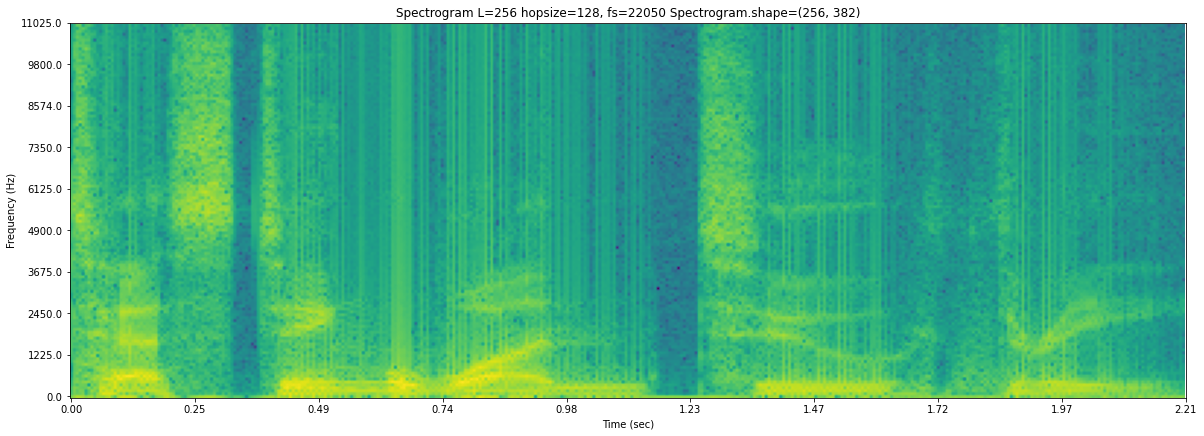

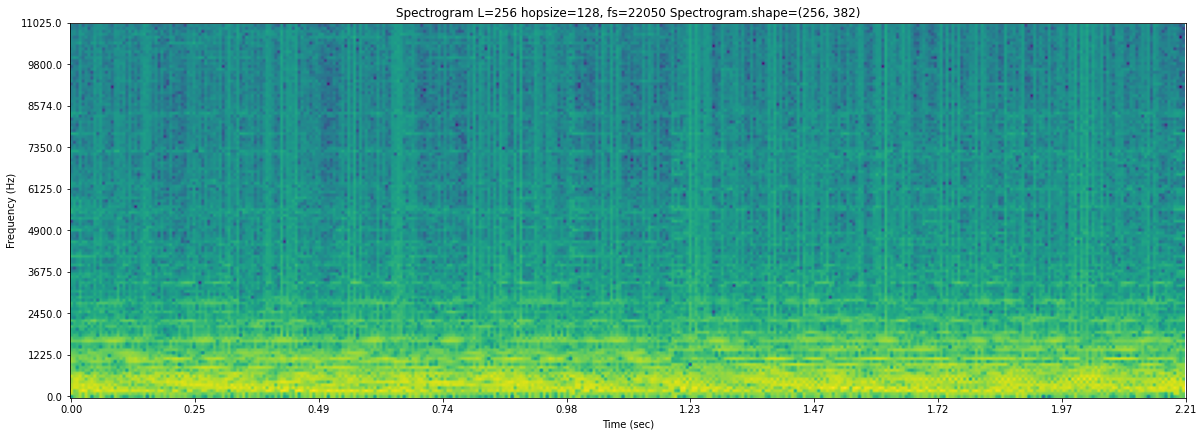

length carrier: 49134, modulator: 49134
carrier stft shape:(256, 382) | modulator spec env shape:(256, 382)
128
(256,)
12928
(256,)
25728
(256,)
38528
(256,)


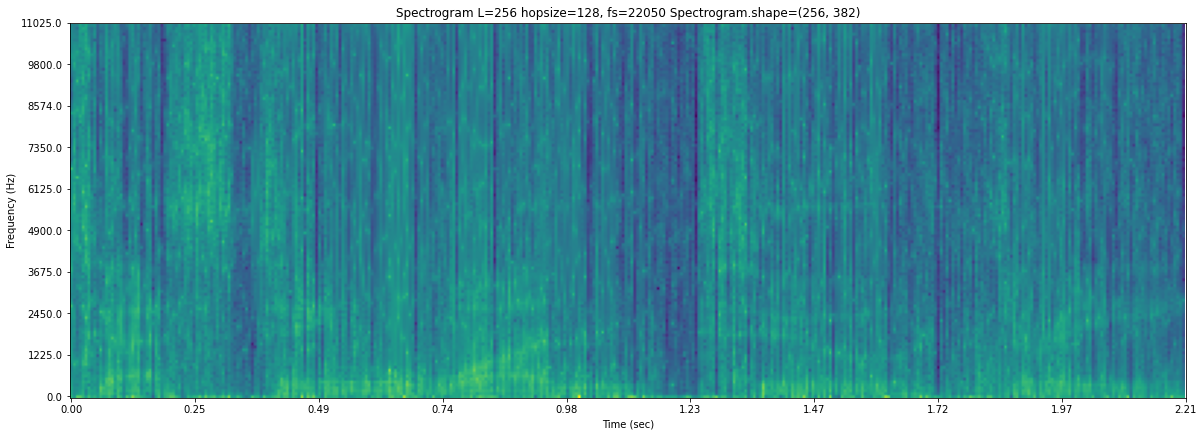

In [96]:
M = 20
L = 256
hop = 128
freq_spec = np.arange(L/2)*fs/L


ms, modulator_stft = get_stft(modulator, L, hop)
plot_spectrogram(ms, modulator_stft, fs, hop)

ms, carrier_stft = get_stft(carrier, L, hop)
plot_spectrogram(ms, carrier_stft, fs, hop)

ms, cross_synth_stft, cross_synth_audio = cross_synthesize(modulator, carrier, L, hop, M)
plot_spectrogram(ms, cross_synth_stft, fs, hop)

In [97]:
Audio(cross_synth_audio, rate=fs)

In [95]:
r_mod = get_istft(modulator_stft, hop)

print(r_mod.real)
print(r_mod.shape)
print(modulator_stft.shape)

Audio(r_mod, rate=fs)


128
(256,)
12928
(256,)
25728
(256,)
38528
(256,)
[-1.33984375 -1.2734375  -1.48828125 ... -2.2421875  -2.39453125
 -2.125     ]
(49152,)
(256, 382)
